Current CV =  2
Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 25, 'n_estimators': 10}
Test set accuracy: 0.768
              precision    recall  f1-score   support

    negative       0.82      0.69      0.75       124
    positive       0.73      0.85      0.79       126

    accuracy                           0.77       250
   macro avg       0.78      0.77      0.77       250
weighted avg       0.77      0.77      0.77       250

Linear Results
Accuracy Score:  0.768
F1- Score:  0.7867647058823529
Recall:  0.8492063492063492
Precision:  0.7328767123287672
[[ 85  39]
 [ 19 107]]
              precision    recall  f1-score   support

    negative       0.82      0.69      0.75       124
    positive       0.73      0.85      0.79       126

    accuracy                           0.77       250
   macro avg       0.78      0.77      0.77       250
weighted avg       0.77      0.77      0.77       250

Current CV =  3
Best hyp

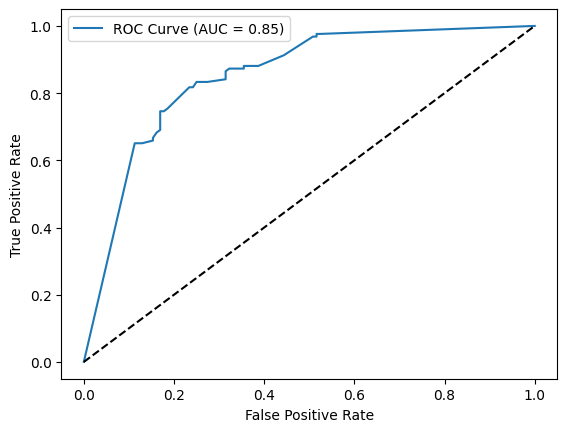

In [14]:
import datura
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, train_test_split
from lime import lime_tabular

df = pd.read_csv('Movie_Reviews.csv', nrows=1000)
trainReviews = df['review']
target = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(trainReviews, target, test_size=0.25)

vectorizer = TfidfVectorizer()

train_matrix = vectorizer.fit_transform(X_train).toarray()
test_matrix = vectorizer.transform(X_test).toarray()

pca = PCA(n_components=500)
train_matrix_pca = pca.fit_transform(train_matrix)
test_matrix_pca = pca.transform(test_matrix)

lda = LinearDiscriminantAnalysis()
lda_X_train = lda.fit_transform(train_matrix_pca, y_train)
lda_X_test = lda.transform(test_matrix_pca)
 
best_acc = -1
best_cv = 0
best_report = None
best_estimator = None
best_y_pred = None
best_y_test= None

def Predict_And_Plot_Results(X_train, X_test, y_train, y_test):
    
    global best_acc
    global best_cv
    global best_report
    global best_estimator
    global best_y_pred
    global best_y_test
    
    rf = RandomForestClassifier()

    param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 10, 15, 20, None],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2,5,10,25]
    }

    for cv in range(2, 10):
        print("Current CV = ", cv)

        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        print("Best hyperparameters:", grid_search.best_params_)

        best_rf = grid_search.best_estimator_
        score =  best_rf.score(X_test, y_test)
        print("Test set accuracy:", score)
    
        y_pred = best_rf.predict(X_test)
        report = classification_report(y_test, y_pred)
        print(report)

        score = accuracy_score(y_test, y_pred)
        conf_mtx = confusion_matrix(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, pos_label='positive')
        recall = recall_score(y_test, y_pred,pos_label='positive')
        precision = precision_score(y_test, y_pred,pos_label='positive')
    
        if score > best_acc:
           best_acc = score
           best_estimator = grid_search.best_estimator_
           best_report = report
           best_cv = cv
           best_y_pred = y_pred
           best_y_test = y_test
  
    
        print("Linear Results")
        print("Accuracy Score: ", score)
        print("F1- Score: ", f1)
        print("Recall: ",recall)
        print("Precision: ", precision)
        print(conf_mtx)
        print(report)
    
    
Predict_And_Plot_Results(lda_X_train, lda_X_test, y_train, y_test)

X_embedded = TSNE(n_components=2, learning_rate='auto', verbose=True).fit_transform(test_matrix)

y_proba = best_estimator.predict_proba(lda_X_test)

sentiment_mapping = {'positive': 1, 'negative': 0} 
mapped_y_test = best_y_test.map(sentiment_mapping)

fpr, tpr, thresholds = roc_curve(mapped_y_test, y_proba[:, 1])
auc_score = roc_auc_score(mapped_y_test, y_proba[:, 1])

#Não consegui plotar esse gráfico. Usando VSCode
explainer = shap.Explainer(best_estimator, train_matrix)
shap_values = explainer(X_embedded)
plot = shap.force_plot(explainer.expected_value[0], shap_values.values[0], X_embedded[0], matplotlib=False)

print("Best results")
print("Best report",best_report)
print("Best acc",best_acc)
print("Best estimator",best_estimator)
print("Best cv: ", best_cv)
print("Auc_Score: ", auc_score)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

